# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.


In [11]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [12]:
def reading_image(image_path):
    """ Read Image from Path
    This will return an image
    will print also some image details
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    return image

def show_image(title,img,cmap=None):
    """Display image with Title
    
    #call as show_image(GRAY_IMAGE, cmap='gray') to show a grayscaled image
    """
    plt.figure()
    plt.title(title)
    plt.imshow(img,cmap)

In [13]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """Calculate the average slope and average intersect"""
    img_height = image.shape[0]
    img_widtht = image.shape[1]
    
    positive_slope = 0
    positive_intersection = 0
    positive_count = 0
    negative_slope = 0
    negative_intersection = 0 
    negative_count = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # calculate slope
            slope = (y2 - y1)/(x2-x1)
            # calculate intersection
            intersection = y1 - (slope*x1)
            
            if slope > 0:
                # Right Line
                positive_slope +=slope
                positive_intersection += intersection
                positive_count +=1
            elif slope < 0:
                # Left Line
                negative_slope +=slope
                negative_intersection += intersection
                negative_count +=1
    
    # Handle zero cases
    average_positive_slope =  0.01 if positive_count == 0 else positive_slope/positive_count
    average_positive_intersection =  0.01 if positive_count == 0 else positive_intersection/positive_count
    average_negative_slope =  0.01 if negative_count == 0 else  negative_slope/negative_count
    average_negative_intersection =  0.01 if negative_count == 0 else negative_intersection/negative_count
    
    # Drow Lines
    cv2.line(img,
             (math.ceil((img_height-average_positive_intersection)/average_positive_slope), img_height),
             (math.ceil((img_height*0.61-average_positive_intersection)/average_positive_slope),
              math.ceil(img_height*0.61)), (255, 0, 0), 10)
    cv2.line(img,
             (math.ceil((img_height-average_negative_intersection)/average_negative_slope), img_height),
             (math.ceil((img_height*0.61-average_negative_intersection)/average_negative_slope),
              math.ceil(img_height*0.61)), (255, 0, 0), 10)
    
    
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def mark_lanes(hough_lines_img, image):
    """
    Takes hough_lines, image as input and returns combined image
    """
    #now let us draw weighted image with hough_lines on top of original image
    blank = np.zeros_like(hough_lines_img)
    color_edges = np.dstack((hough_lines_img, blank, blank))
    combined_image = weighted_img(color_edges,image)
    return combined_image


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


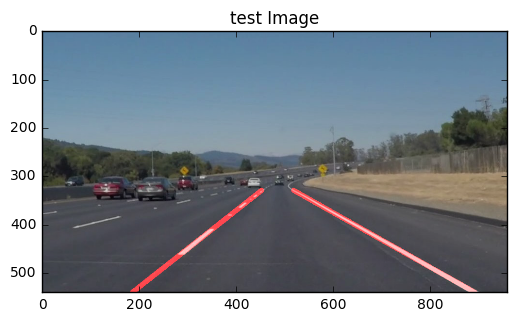

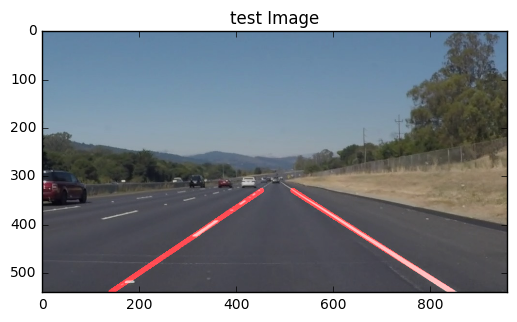

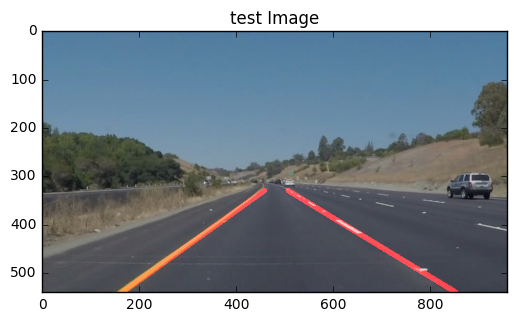

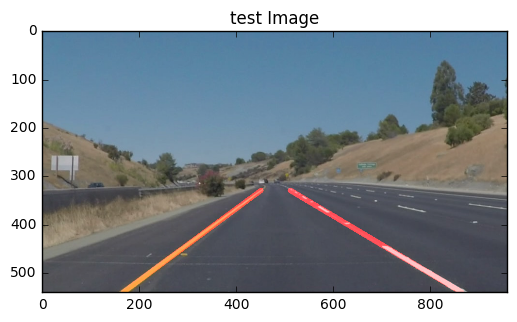

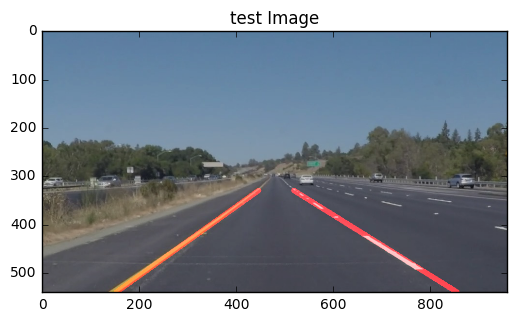

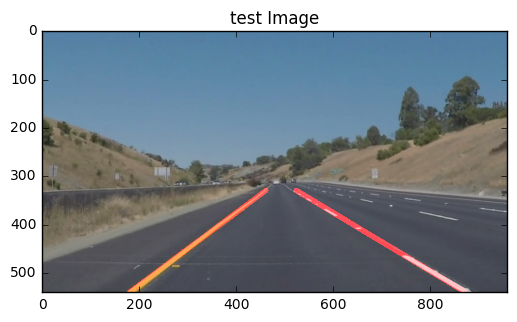

In [14]:
import os

def filter_image(image):
    """Filter image and return canny edges image """    
    # convert image to gray
    gray_image = grayscale(image)        
    # remove noise 
    kernel_size = 5
    filterd_image = gaussian_blur(gray_image, kernel_size)    
    # get edges from image
    edges = canny(filterd_image, 50, 150)    
    return edges

def mask_image(test_image, edges):
    # get image shape (height, width, number of channels)
    imshape = test_image.shape
    vertices = np.array([[(imshape[1]*.06,imshape[0]*.95),(imshape[1]/2-20, imshape[0]*.60), 
                          (imshape[1]/2 + 20, imshape[0]*.60), (imshape[1]*.94,imshape[0]*.95)]], dtype=np.int32)
    masked_image = region_of_interest(edges,vertices)
    return masked_image

def get_line_image(masked_image):
    rho = 2
    theta = np.pi/180
    threshold = 45
    min_line_length = 100
    max_line_gap = 140    
    line_img = hough_lines(masked_image,rho, theta, threshold, min_line_length, max_line_gap)
    return line_img

def process_single_image(test_image):    
    edges = filter_image(test_image)    
    masked_image = mask_image(test_image, edges)
    line_img = get_line_image(masked_image)    
    combo = weighted_img(line_img, test_image)
    return combo

# Read and save test images to array
test_images = [reading_image('test-images/' + i) for i in os.listdir('test-images/')]
for image in test_images:
    show_image("test Image",process_single_image(image))

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return process_single_image(image)

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = 'result-videos\white.mp4'
clip1 = VideoFileClip("test-videos\solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result-videos\white.mp4
[MoviePy] Writing video result-videos\white.mp4


100%|█████████████████████████████████████████████████████▊| 221/222 [00:03<00:00, 55.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result-videos\white.mp4 

Wall time: 4.28 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'result-videos\yellow.mp4'
clip2 = VideoFileClip('test-videos\solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video result-videos\yellow.mp4
[MoviePy] Writing video result-videos\yellow.mp4


100%|█████████████████████████████████████████████████████▉| 681/682 [00:11<00:00, 61.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result-videos\yellow.mp4 

Wall time: 12.2 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Like we have learned in the video, we have found the lane lines in a picture. I have made the same steps, and after that I have worked on finding the better line. The main algorithm is coded in the "draw_lines" function where I took the average slope and intersection of left and right lines detected, as suggested by the instructors and drew respectively the left and then the right lines. 

Till now my algorithm doesn’t pass the optional challenge and even it has some weakness in the second video "yellow.mp4". I think the algorithm fail when the lane lines has a horizontal line on the left lane line.

working on improving the algorithm will be the next step.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'result-videos\extra.mp4'
clip2 = VideoFileClip('test-videos\challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))